In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

total_data = pd.read_csv('./scraped_data.csv')

In [ ]:
unique_categories = set()
for categories in total_data['categoryNames']:
    categories_list = eval(categories)
    unique_categories.update(categories_list)


# Create a new DataFrame with separate columns for each category
new_columns = {category: [] for category in unique_categories}
for categories in total_data['categoryNames']:
    for category in unique_categories:
        new_columns[category].append(1 if category in categories else 0)

# Filter out duplicate columns
new_df = pd.DataFrame(new_columns).groupby(level=0, axis=1).max()

# Concatenate the new DataFrame with the original DataFrame
new_data_set = pd.concat([total_data, new_df], axis=1)


In [30]:
x=new_data_set.iloc[:,3:].sum()
rowsums=new_data_set.iloc[:,3:].sum(axis=1)
no_label_count = 0
for sum in rowsums.items():
    if sum==0:
        no_label_count +=1

print("Total number of items = ",len(new_data_set))
print("Total number of items without label = ",no_label_count)
print("Total labels = ", x.sum())

Total number of items =  10009
Total number of items without label =  0
Total labels =  51804


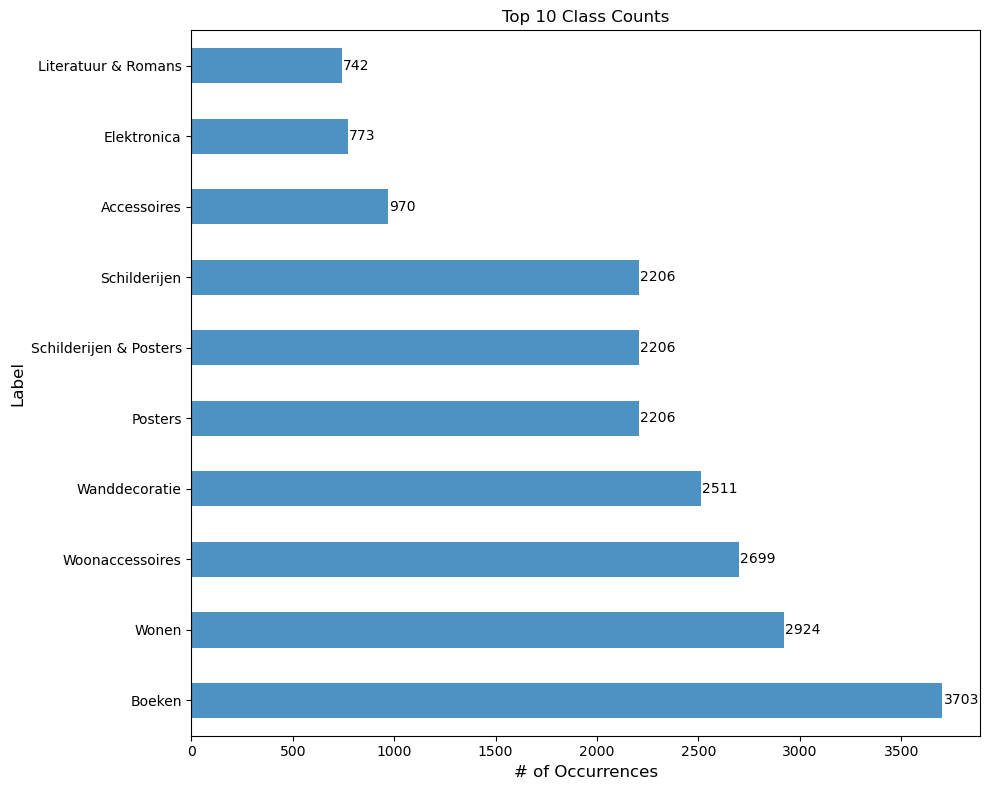

In [31]:
import matplotlib.pyplot as plt

x = new_data_set.iloc[:, 3:].sum()

# Sort the data in descending order
x_sorted = x.sort_values(ascending=False)

# Set the number of labels to display
num_labels = 10  # Adjust the number as needed

# Select the top 'num_labels' labels and their corresponding values
x_top = x_sorted[:num_labels]

plt.figure(figsize=(10, 8))
ax = x_top.plot(kind='barh', alpha=0.8)

plt.title("Top {} Class Counts".format(num_labels))
plt.xlabel('# of Occurrences', fontsize=12)
plt.ylabel('Label', fontsize=12)

# Add data value labels to the bars
for i, v in enumerate(x_top.values):
    ax.text(v + 5, i, str(v), va='center')

plt.tight_layout()
plt.show()

In [ ]:
new_data_set['Text']=new_data_set['title']+' '+new_data_set['subTitle']
new_data_set.drop(columns=['categoryNames','title','subTitle'], inplace=True)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

nltk.download('stopwords')

languages = set(['Arabic', 'Danish', 'Dutch', 'English', 'Finnish', 'French', 'German', 'Hungarian', 'Italian', 'Norwegian', 'Portuguese', 'Romanian', 'Russian', 'Spanish', 'Swedish'])
custom_stop_words = set()


for language in languages:
    # Remove Stopwords
    stop_words = set(stopwords.words(language.lower()))

    # Update the custom_stop_words set with stop_words for each language
    custom_stop_words.update(stop_words)

    # Function to remove stopwords from a list of words
    def remove_stopwords(text):
        no_stopword_text = [w for w in text if not w in stop_words]
        return no_stopword_text

    # Clean Text: Remove non-alphabetic characters and extra whitespaces from a list of words
    def clean_text(text):
        text = [re.sub("[^a-zA-Z]"," ", t) for t in text]
        text = [' '.join(t.split()) for t in text]
        return text

    # Stemming: Apply stemming to a list of words
    stemmer = SnowballStemmer(language.lower())
    def stemming(sentence):
        if isinstance(sentence, str):
            stemSentence = ""
            for word in sentence.split():
                stem = stemmer.stem(word)
                stemSentence += stem
                stemSentence += " "
            stemSentence = stemSentence.strip()
            return stemSentence
        else:
            return sentence

    # Apply text preprocessing functions to 'Text' column
    new_data_set['Text'] = new_data_set['Text'].apply(lambda x: remove_stopwords(x) if isinstance(x, list) else x)
    new_data_set['Text'] = new_data_set['Text'].apply(lambda x: clean_text(x) if isinstance(x, list) else x)
    new_data_set['Text'] = new_data_set['Text'].apply(stemming)
    print(stop_words)

In [36]:

# Remove the [''] substring from the 'Text' column
new_data_set['Text'] = new_data_set['Text'].apply(lambda x: x.replace("['']", "") if not isinstance(x, float) else x)

new_data_set = new_data_set.dropna(subset=['Text'])

new_data_set['Text'] = new_data_set['Text'].apply(lambda x: re.sub(r'\W+', ' ', str(x)))
new_data_set['Text'] = new_data_set['Text'].apply(lambda x: re.sub(r'\d+', '', str(x)))  




In [ ]:
X = new_data_set['Text']

new_data_set.drop(columns=['Text'], inplace=True)

y = new_data_set

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25) # by default train_test_split uses 25% of the data for the test set

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7461,), (2488,), (7461, 3062), (2488, 3062))

In [41]:
custom_stop_words_list = list(custom_stop_words)

pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=custom_stop_words_list)),
                ('clf',  LabelPowerset(LogisticRegression(max_iter=120))),
            ])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

print("Accuracy = ",accuracy_score(y_test,predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))


/Users/jessehuijts/Desktop/ml-hello-world/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Accuracy =  0.37741157556270094
F1 score is  0.6003998857469294
Hamming Loss is  0.0011018269798232037


In [ ]:
predictions = pipeline.predict(['ASUS VivoBook M1605YA-MB451W - Laptop - 16 inch'])

In [64]:

# Assuming you have a DataFrame called 'df'
column_index = 508

# Search for the column index in the DataFrame
column_name = y_train.columns[column_index]

# Print the column name
print(column_name)

Computer


In [65]:
from joblib import dump, load

# Save a model to file
file_name_model_joblib = "logistic_regression_model.joblib"
dump(pipeline, filename=file_name_model_joblib) 

['logistic_regression_model.joblib']

In [66]:
loaded_joblib_model = load(filename=file_name_model_joblib)

In [ ]:
joblib_model_prediction = loaded_joblib_model.predict(['Beyoncé - Cowboy Carter (CD)'])

In [70]:

column_index = 1732

# Search for the column index in the DataFrame
column_name = y_train.columns[column_index]

# Print the column name
print(column_name)

Muziek
